In [1]:
import os
import math
import cv2
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from keras.layers import Activation, Dense, Flatten
from sklearn.model_selection import train_test_split

# In[2]:
#path_name = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
#path_data = os.listdir('/kaggle/input/lgg-mri-segmentation/kaggle_3m')
#image = []
#mask = []
#name = []
#for i in path_data:
    #if i!='data.csv' and i!='README.md':
        #path_one_brain_name = os.path.join(path_name,i)
        #path_one_brain = os.listdir(path_one_brain_name)
        #for j in path_one_brain:
            #if j.endswith('.tif') and not j.endswith('_mask.tif'):
                #img = cv2.imread(os.path.join(path_one_brain_name,j))
                #img = cv2.resize(img,(128,128))
                #msk = cv2.imread(os.path.join(path_one_brain_name,j.removesuffix('.tif')+'_mask.tif'))
                #msk = cv2.resize(msk,(128,128))
                #grayImage = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
                #(thresh, msk) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
                #image.append(img)
                #mask.append(msk)
                #name.append(j)
                

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **DATA AUGMENTATIONS**

In [2]:
def obtain_data(path,split=0.2):
    images = sorted(glob(os.path.join(path,"images","*.png")))
    masks = sorted(glob(os.path.join(path,"masks","*.png")))
    split_size = int(len(images)*split)
    train_x,test_x,train_y,test_y = train_test_split(images,masks,test_size=split_size,random_state = 42)
    train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size=split_size,random_state = 42)
    return (train_x,train_y),(test_x,test_y),(val_x,val_y)

In [3]:
path = '/kaggle/input/brain-tumor-segmentation'
(x_train,y_train),(x_test,y_test),(x_val,y_val) = obtain_data(path)

In [4]:
def read_image(path,ismask = 0):
    path = path.decode()
    if(ismask == 1):
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.convertScaleAbs(img, alpha=1.5,beta=0)
        img = cv2.resize(img,(256,256))
        img = img/255.0
        img = np.expand_dims(img,axis = -1)
        img = img.astype(np.float32)
    else:
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(256,256))
        img = img / 255.0
        img = img.astype(np.float32)
    return img

In [5]:
def tf_parse(x,y):
    def _parse(x,y):
        x = read_image(x)
        y = read_image(y,1)
        return x,y
    x,y = tf.numpy_function(_parse,[x,y],[tf.float32,tf.float32])
    x.set_shape([256,256,3])
    y.set_shape([256,256,1])
    return x, y

In [6]:
def tf_dataset(X,Y,batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X,Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [7]:
batch_size=16
learning_r=1e-5
num_epochs=500

In [8]:
train_dataset = tf_dataset(x_train,y_train,batch=batch_size)
test_dataset = tf_dataset(x_test,y_test,batch=batch_size)
val_dataset = tf_dataset(x_val,y_val,batch=batch_size)

In [9]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

In [10]:
#images = np.array(images)
#masks = np.array(masks)

In [11]:
#images.shape,masks.shape

In [12]:
#from keras.utils import normalize
#masks_normal = np.expand_dims(masks,3)/255.

In [13]:
#masks_normal.shape

# **SANITY CHECK FOR OVERLAY OF IMAGE**

In [14]:
#img_plot_1 = plt.imshow(images[4],interpolation='none')
#img_plot_2 = plt.imshow(masks[4],interpolation='none',alpha=0.7)
#plt.show()

In [15]:
#from sklearn.preprocessing import LabelEncoder
#labelencoder = LabelEncoder()
#n, h, w = masks.shape
#train_masks_reshaped = masks.reshape(-1,1)
#train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped.ravel())
#train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

#print(np.unique(train_masks_encoded_original_shape))
#print(train_masks_encoded_original_shape.shape)

In [16]:
#train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis = 3)
#print(train_masks_input.shape)

# **LOSS FUNCTIONS**

In [17]:
import keras.backend as K
smooth_iou = 0.001

def jacard_coeff(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    i = K.sum(y_true_f * y_pred_f) + smooth_iou
    u = K.sum(y_true_f) + K.sum(y_pred_f) - i + smooth_iou
    iou = i/u
    return iou
def jacard_coeff_loss(y_true,y_pred):
    return 1.0-jacard_coeff(y_true,y_pred)

In [18]:
smooth_dice = 1e-15
def dice_coeff(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return ((2. * intersection+smooth) / (K.sum(y_true) + K.sum(y_pred)+smooth))

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coeff(y_true, y_pred)

In [19]:
smooth=1e-6

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    gamma = 0.75
    return K.pow((1-tversky(y_true, y_pred)), gamma)

# **U-NET MODEL**

In [20]:
initial = 16
inputs = tf.keras.layers.Input((256,256,3))
c1 = tf.keras.layers.Conv2D(initial,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
c1 = tf.keras.layers.BatchNormalization()(c1)
c1 = tf.keras.layers.Dropout(0.2)(c1)
c1 = tf.keras.layers.Conv2D(initial,(3,3),padding='same')(c1)
c1 = tf.keras.layers.BatchNormalization()(c1)
c1 = tf.keras.layers.Activation('relu')(c1)
p1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c1)


# Layer 2

# In[8]:


c2 = tf.keras.layers.Conv2D(initial*2,(3,3),padding='same')(p1)
c2 = tf.keras.layers.BatchNormalization()(c2)
c2 = tf.keras.layers.Activation('relu')(c2)
c2 = tf.keras.layers.Dropout(0.3)(c2)
c2 = tf.keras.layers.Conv2D(initial*2,(3,3),padding='same')(c2)
c2 = tf.keras.layers.BatchNormalization()(c2)
c2 = tf.keras.layers.Activation('relu')(c2)
p2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c2)


# Layer 3

# In[9]:


c3 = tf.keras.layers.Conv2D(initial*4,(3,3),padding='same')(p2)
c3 = tf.keras.layers.BatchNormalization()(c3)
c3 = tf.keras.layers.Activation('relu')(c3)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(initial*4,(3,3),padding='same')(c3)
c3 = tf.keras.layers.BatchNormalization()(c3)
c3 = tf.keras.layers.Activation('relu')(c3)
p3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c3)


# Layer 4

# In[10]:


c4 = tf.keras.layers.Conv2D(initial*8,(3,3),padding='same')(p3)
c4 = tf.keras.layers.BatchNormalization()(c4)
c4 = tf.keras.layers.Activation('relu')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(initial*8,(3,3),padding='same')(c4)
c4 = tf.keras.layers.BatchNormalization()(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c4)


# Layer 5

# In[11]:


c5 = tf.keras.layers.Conv2D(initial*16,(3,3),padding='same')(p4)
c5 = tf.keras.layers.BatchNormalization(axis = 3)(c5)
c5 = tf.keras.layers.Activation('relu')(c5)
c5 = tf.keras.layers.Dropout(0.2)(c5)
c5 = tf.keras.layers.Conv2D(initial*16,(3,3),padding='same')(c5)
c5 = tf.keras.layers.BatchNormalization(axis = 3)(c5)
c5 = tf.keras.layers.Activation('relu')(c5)


# Expansive Path:
# 
# Layer 1

# In[12]:


u6 = tf.keras.layers.Conv2DTranspose(initial*8,(2,2),strides=(2,2),padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(initial*8,(3,3),padding='same')(u6)
c6 = tf.keras.layers.BatchNormalization()(c6)
c6 = tf.keras.layers.Activation('relu')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(initial*8,(3,3),padding='same')(c6)
c6 = tf.keras.layers.BatchNormalization()(c6)
c6 = tf.keras.layers.Activation('relu')(c6)


# Layer 2

# In[13]:


u7 = tf.keras.layers.Conv2DTranspose(initial*4,(2,2),strides=(2,2),padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(initial*4,(3,3),padding='same')(u7)
c7 = tf.keras.layers.BatchNormalization()(c7)
c7 = tf.keras.layers.Activation('relu')(c7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(initial*4,(3,3),padding='same')(c7)
c7 = tf.keras.layers.BatchNormalization()(c7)
c7 = tf.keras.layers.Activation('relu')(c7)


# Layer 3

# In[14]:


u8 = tf.keras.layers.Conv2DTranspose(initial*2,(2,2),strides=(2,2),padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
u8 = tf.keras.layers.Dropout(0.2)(u8)
c8 = tf.keras.layers.Conv2D(initial*2,(3,3),padding='same')(u8)
c8 = tf.keras.layers.BatchNormalization()(c8)
c8 = tf.keras.layers.Activation('relu')(c8)
c8 = tf.keras.layers.Dropout(0.15)(c8)
c8 = tf.keras.layers.Conv2D(initial*2,(3,3),padding='same')(c8)
c8 = tf.keras.layers.BatchNormalization()(c8)
c8 = tf.keras.layers.Activation('relu')(c8)


# Layer 4

# In[15]:


u9 = tf.keras.layers.Conv2DTranspose(initial,(2,2),strides=(2,2),padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1])
c9 = tf.keras.layers.Conv2D(initial,(3,3),padding='same')(u9)
c9 = tf.keras.layers.BatchNormalization()(c9)
c9 = tf.keras.layers.Activation('relu')(c9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(initial,(3,3),padding='same')(c9)
c9 = tf.keras.layers.BatchNormalization()(c9)
c9 = tf.keras.layers.Activation('relu')(c9)

# Layer 5

# In[16]:

outputs = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid',kernel_regularizer = tf.keras.regularizers.L1(0.01))(c9)


# In[17]:

#learning_rate = 0.00001
#decay_rate = learning_rate / 500

model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
opt = tf.keras.optimizers.Adam(learning_rate=1e-4,clipvalue = 1)
model.compile(optimizer = opt,loss = dice_loss,metrics=[jacard_coeff])
model.summary()

callbacks = [tf.keras.callbacks.ModelCheckpoint('Brain_tumour_model_mask.h5',verbose=1,save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-7,patience=10,verbose=1),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=50,verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(train_dataset,validation_data=val_dataset,batch_size=batch_size,epochs=300,callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['batch_normalization[0][0

2023-11-28 14:27:03.556845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


115/115 [==============================] - ETA: 0s - loss: 0.9781 - jacard_coeff: 0.0296
Epoch 1: val_loss improved from inf to 0.99668, saving model to Brain_tumour_model_mask.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/115 [==============================] - 61s 331ms/step - loss: 0.9781 - jacard_coeff: 0.0296 - val_loss: 0.9967 - val_jacard_coeff: 0.0195 - lr: 1.0000e-04
Epoch 2/300
115/115 [==============================] - ETA: 0s - loss: 0.9478 - jacard_coeff: 0.0456
Epoch 2: val_loss improved from 0.99668 to 0.99455, saving model to Brain_tumour_model_mask.h5
115/115 [==============================] - 20s 176ms/step - loss: 0.9478 - jacard_coeff: 0.0456 - val_loss: 0.9946 - val_jacard_coeff: 0.0208 - lr: 1.0000e-04
Epoch 3/300
115/115 [==============================] - ETA: 0s - loss: 0.9333 - jacard_coeff: 0.0541
Epoch 3: val_loss improved from 0.99455 to 0.99429, saving model to Brain_tumour_model_mask.h5
115/115 [==============================] - 21s 181ms/step - loss: 0.9333 - jacard_coeff: 0.0541 - val_loss: 0.9943 - val_jacard_coeff: 0.0215 - lr: 1.0000e-04
Epoch 4/300
115/115 [==============================] - ETA: 0s - loss: 0.9227 - jacard_coeff: 0.0605
Epoch 4: val_loss improved fro

# **OUTPUT EVALUATION**

In [21]:
model.compile(optimizer = opt, loss = focal_tversky, metrics = [dice_coeff,jacard_coeff , 'accuracy'])
print("Evaluate on test data")
results = model.evaluate(test_dataset,batch_size = batch_size)

Evaluate on test data
39/39 [==============================] - 14s 343ms/step - loss: 0.3562 - dice_coeff: 0.7965 - jacard_coeff: 0.6670 - accuracy: 0.9933


1/1 [==============================] - 1s 739ms/step


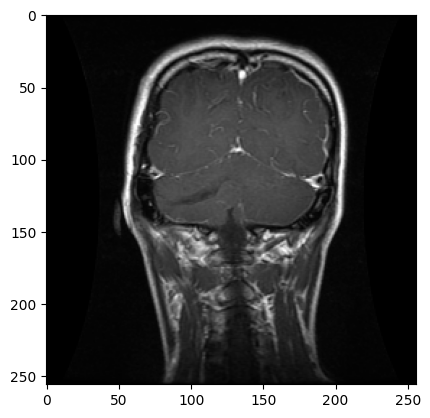

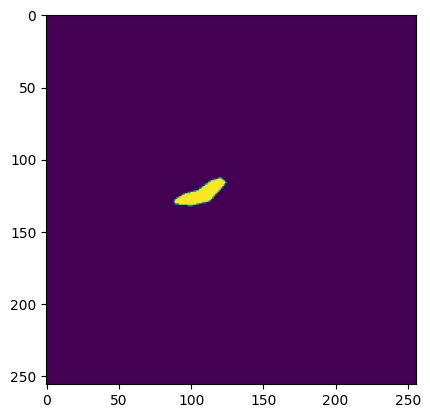

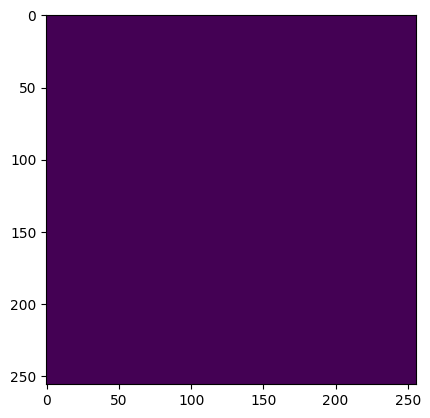

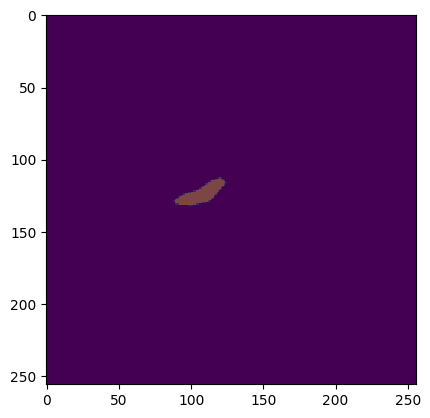

In [22]:
import random
num = random.randrange(0,len(x_test)-1)

test_img = cv2.imread(x_test[num],cv2.IMREAD_COLOR)
test_img = cv2.convertScaleAbs(test_img, alpha=1.5,beta=0)
x1 = cv2.resize(test_img , (256,256))
x_1 = x1/255.0
x_1 = np.expand_dims(x_1,axis=0)
#test_img1 = cv2.imread(x_test[num],cv2.IMREAD_COLOR)
#x2 = cv2.resize(test_img1 , (128,128))
#x_2 = x2/255.0
#x_2 = np.expand_dims(x_2,axis=0)
mask = cv2.imread(y_test[num],cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask,(256,256))
y_pred = model.predict(x_1)
y_pred = np.squeeze(y_pred , axis = 0)
y_pred = y_pred>=0.5
img_plt_1 = plt.imshow(x1)
plt.show()
img_plot_2 = plt.imshow(mask)
plt.show()
img_plot_3 = plt.imshow(y_pred)
plt.show()
img_plot_4 = plt.imshow(mask,interpolation='none')
img_plot_5 = plt.imshow(y_pred,interpolation='none',alpha=0.7)
plt.show()

1/1 [==============================] - 0s 20ms/step


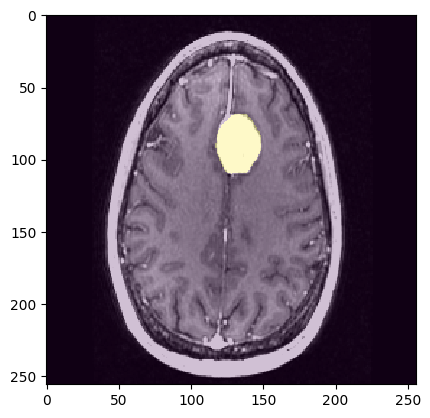

In [23]:
real_img = cv2.imread('/kaggle/input/realimg/big_5b252c1a32b7d.jpg',cv2.IMREAD_COLOR)
real_img = cv2.convertScaleAbs(real_img, alpha=1.5,beta=0)
x1 = cv2.resize(real_img , (256,256))
x_1 = x1/255.0
x_1 = np.expand_dims(x_1,axis=0)
y_pred = model.predict(x_1)
y_pred = np.squeeze(y_pred , axis = 0)
y_pred = y_pred>=0.5
img_plot_4 = plt.imshow(x1,interpolation='none')
img_plot_5 = plt.imshow(y_pred,interpolation='none',alpha=0.25)
plt.show()